In [21]:
import FlexPlan; const _FP = FlexPlan
import PowerModelsACDC; const _PMACDC = PowerModelsACDC
import PowerModels; const _PM = PowerModels
import InfrastructureModels; const _IM = InfrastructureModels

import JuMP
import Cbc

Solver configurations:

In [22]:
cbc = JuMP.with_optimizer(Cbc.Optimizer, tol=1e-4, print_level=0)

MathOptInterface.OptimizerWithAttributes(Cbc.Optimizer, Pair{MathOptInterface.AbstractOptimizerAttribute,Any}[MathOptInterface.RawParameter("tol") => 0.0001, MathOptInterface.RawParameter("print_level") => 0])

Input parameters:

In [23]:
number_of_hours = 60 # Number of time points
file = "./test/data/case6_reliability.m";  #Input case, in matpower m-file format: Here 6bus case with candidate AC, DC lines and candidate storage

Define contingency scenarios:

In [33]:
scenario = Dict{String, Any}("hours" => number_of_hours, "contingency" => Dict{String, Any}())
# Base scenario
scenario["contingency"]["0"] = Dict{String, Any}()
scenario["contingency"]["0"]["year"] = 2019
scenario["contingency"]["0"]["start"] = 1546300800000   # 01.01.2019:00:00 in epoch time
scenario["contingency"]["0"]["probability"] = 0.98
scenario["contingency"]["0"]["faults"] = Dict()
# Contingency 1
#scenario["contingency"]["1"] = Dict{String, Any}()
#scenario["contingency"]["1"]["year"] = 2019
#scenario["contingency"]["1"]["start"] = 1546300800000   # 01.01.2019:00:00 in epoch time
#scenario["contingency"]["1"]["probability"] = 0.01
#scenario["contingency"]["1"]["faults"] = Dict("branchdc" => [1])  
# Contingency 2
#scenario["contingency"]["2"] = Dict{String, Any}()
#scenario["contingency"]["2"]["year"] = 2019
#scenario["contingency"]["2"]["start"] = 1546300800000 # 01.01.2019:00:00 in epoch time 
#scenario["contingency"]["2"]["probability"] = 0.01
#scenario["contingency"]["2"]["faults"] = Dict("branchdc_ne" => [3])
# Contingency 3
#scenario["contingency"]["3"] = Dict{String, Any}()
#scenario["contingency"]["3"]["year"] = 2019
#scenario["contingency"]["3"]["start"] = 1546300800000 # 01.01.2019:00:00 in epoch time
#scenario["contingency"]["3"]["probability"] = 0.01
#scenario["contingency"]["3"]["faults"] = Dict("branchdc" => [2])
# Common parameters for all scenarios
scenario["utypes"] = [ "branchdc", "branchdc_ne"] # type of lines considered in contingencies
scenario["planning_horizon"] = 1 # in years, to scale generation cost  

1

# Define and modify input-data

Load system data from file:

In [34]:
data = _PM.parse_file(file) # Create PowerModels data dictionary (AC networks and storage)

[info | PowerModels]: extending matpower format with data: storage_extra 1x4
[info | PowerModels]: extending matpower format with data: convdc 4x35
[info | PowerModels]: extending matpower format with data: busdc 4x9
[info | PowerModels]: extending matpower format with data: convdc_ne 6x37
[info | PowerModels]: extending matpower format with data: ne_storage 1x25
[info | PowerModels]: extending matpower format with data: busdc_ne 4x9
[info | PowerModels]: extending matpower format with data: load_extra 5x19
[info | PowerModels]: extending matpower format with data: branchdc_ne 3x12
[info | PowerModels]: extending matpower format with data: ne_branch 2x15
[info | PowerModels]: extending matpower format with data: branchdc 2x10
[info | PowerModels]: extending matpower format with constant data: time_elapsed
[info | PowerModels]: extending matpower format by appending matrix "storage_extra" in to "storage"
[warn | PowerModels]: the voltage setpoint on generator 2 does not match the value 

Dict{String,Any} with 23 entries:
  "ne_branch"      => Dict{String,Any}("1"=>Dict{String,Any}("br_r"=>0.02,"rate…
  "time_elapsed"   => 1.0
  "branchdc_ne"    => Dict{String,Any}("1"=>Dict{String,Any}("c"=>0.0,"r"=>0.01…
  "bus"            => Dict{String,Any}("4"=>Dict{String,Any}("zone"=>1,"bus_i"=…
  "source_type"    => "matpower"
  "name"           => "case6"
  "dcline"         => Dict{String,Any}()
  "source_version" => "2"
  "gen"            => Dict{String,Any}("4"=>Dict{String,Any}("ncost"=>2,"qc1max…
  "branch"         => Dict{String,Any}("4"=>Dict{String,Any}("br_r"=>0.04,"rate…
  "storage"        => Dict{String,Any}("1"=>Dict{String,Any}("energy_rating"=>1…
  "switch"         => Dict{String,Any}()
  "baseMVA"        => 100.0
  "convdc"         => Dict{String,Any}("4"=>Dict{String,Any}("dVdcset"=>0,"Vtar…
  "load_extra"     => Dict{String,Any}("4"=>Dict{String,Any}("e_nce_max"=>0,"p_…
  "per_unit"       => true
  "ne_storage"     => Dict{String,Any}("1"=>Dict{String,Any}("ener

Create data for the contingency model based on system data and contingency scenarios:

In [35]:

data, contingency_profile, loadprofile, genprofile = _FP.create_contingency_data_italy(data, scenario) # create load and generation profiles
_PMACDC.process_additional_data!(data) # Add DC grid data to the data dictionary
_FP.add_storage_data!(data) # Add addtional storage data model
_FP.add_flexible_demand_data!(data) # Add flexible data model
_FP.scale_cost_data!(data, scenario) # Scale cost data



Translate data profiles into model parameters:

In [36]:
dim = number_of_hours * length(data["contingency"])
extradata = _FP.create_contingency_data(dim, data, contingency_profile, loadprofile, genprofile) # create a dictionary to pass time series 

Dict{String,Any} with 5 entries:
  "gen"         => Dict{String,Any}("4"=>Dict{String,Any}("pmax"=>[1.2 1.2 … 1.…
  "dim"         => 60
  "branchdc_ne" => Dict{String,Any}("1"=>Dict{String,Any}("status"=>[1.0 1.0 … …
  "load"        => Dict{String,Any}("4"=>Dict{String,Any}("pd"=>[0.844133 0.830…
  "branchdc"    => Dict{String,Any}("1"=>Dict{String,Any}("status"=>[1.0 1.0 … …

Create data dictionary where time series data is included at the right place

In [37]:
mn_data = _PMACDC.multinetwork_data(data, extradata, Set{String}(["source_type", "contingency", "contingency_prob", "name", "source_version", "per_unit"]))

Dict{String,Any} with 8 entries:
  "name"             => "60 replicates of case6"
  "contingency"      => Dict{String,Any}("0"=>Dict{Any,Any}("32"=>32,"29"=>29,"…
  "source_version"   => "2"
  "contingency_prob" => Dict{String,Any}("0"=>0.98)
  "multinetwork"     => true
  "nw"               => Dict{String,Any}("32"=>Dict{String,Any}("ne_branch"=>Di…
  "per_unit"         => true
  "source_type"      => "matpower"

# Create and solve optimization model

 Add PowerModels(ACDC) settings

In [38]:
s = Dict("output" => Dict("branch_flows" => true), "conv_losses_mp" => false, "process_data_internally" => false)

Dict{String,Any} with 3 entries:
  "conv_losses_mp"          => false
  "output"                  => Dict{String,Bool}("branch_flows"=>1)
  "process_data_internally" => false

Build optimisation model, solve it and write solution dictionary:

In [39]:
result = _FP.reliability_tnep(mn_data, _PM.DCPPowerModel, cbc, multinetwork=true; setting = s);

ls]: no reference DC bus found, setting reference bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 1 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: no reference DC bus found, setting reference bus based on AC bus type
[warn | PowerModels]: For converter 4 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 2 is chosen P is fixed on AC and DC side. This can lead to infeasibility in the PF problem.
[warn | PowerModels]: For converter 3 is chosen P is fixed on AC 

# Plot and examine results

Illustration of the test network with investment candidates:

<img src="./test/notebooks/images/6_bus_system_ACDC.jpg" height=400 />

Plot energy balance for bus nr. 5

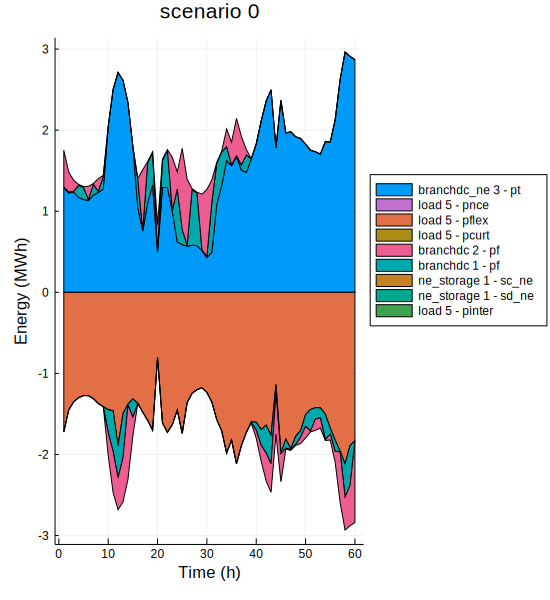

In [40]:
enbal_plot = _FP.plot_energy_balance_scenarios(data, result, "contingency", 5);

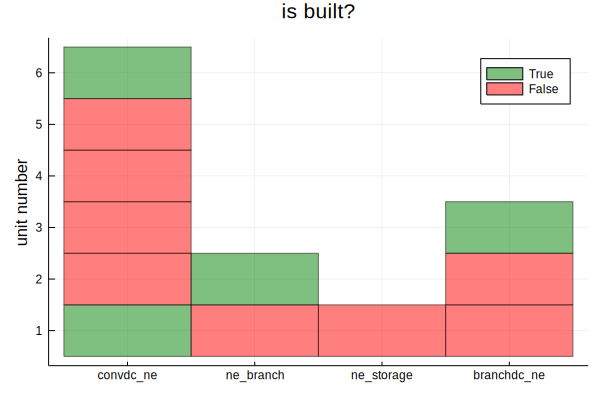

In [41]:
_FP.plot_inv_matrix(result, data["contingency"], "0")

In [42]:
result

Dict{String,Any} with 8 entries:
  "solve_time"         => 10.9593
  "optimizer"          => "COIN Branch-and-Cut (Cbc)"
  "termination_status" => OPTIMAL
  "dual_status"        => NO_SOLUTION
  "primal_status"      => FEASIBLE_POINT
  "objective"          => 60489.5
  "solution"           => Dict{String,Any}("multinetwork"=>true,"nw"=>Dict{Stri…
  "objective_lb"       => 60489.5

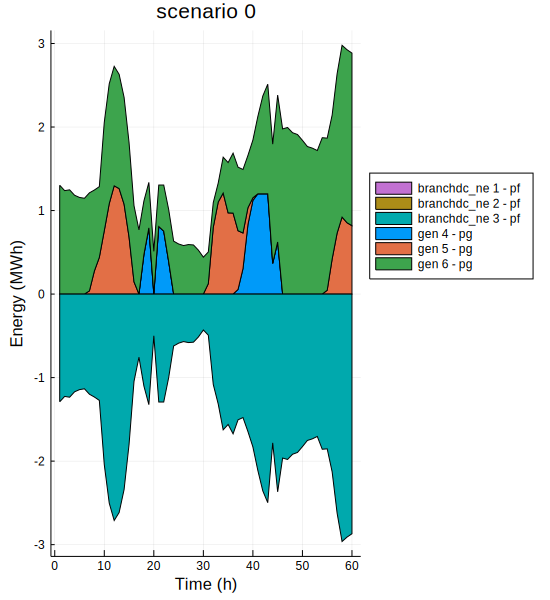

In [43]:
enbal_plot = _FP.plot_energy_balance_scenarios(data, result, "contingency", 6);